In [173]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.circuit.library.raw_feature_vector import RawFeatureVector
import qiskit 
algorithm_globals.random_seed = 12345

In [174]:
qiskit.__version__

'1.1.1'

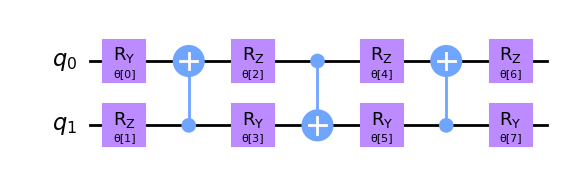

In [175]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.ry(params[0], 0) #new gate
    target.rz(params[1], 1) #was -np.pi / 2
    target.cx(1, 0)
    target.rz(params[2], 0) #was 0
    target.ry(params[3], 1) #was 1
    target.cx(0, 1)
    target.rz(params[4], 0) #new gate 
    target.ry(params[5], 1) #was 2
    target.cx(1, 0)
    target.rz(params[6], 0) #was np.pi / 2
    target.ry(params[7], 1) #new circuit
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=8) #was 3
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

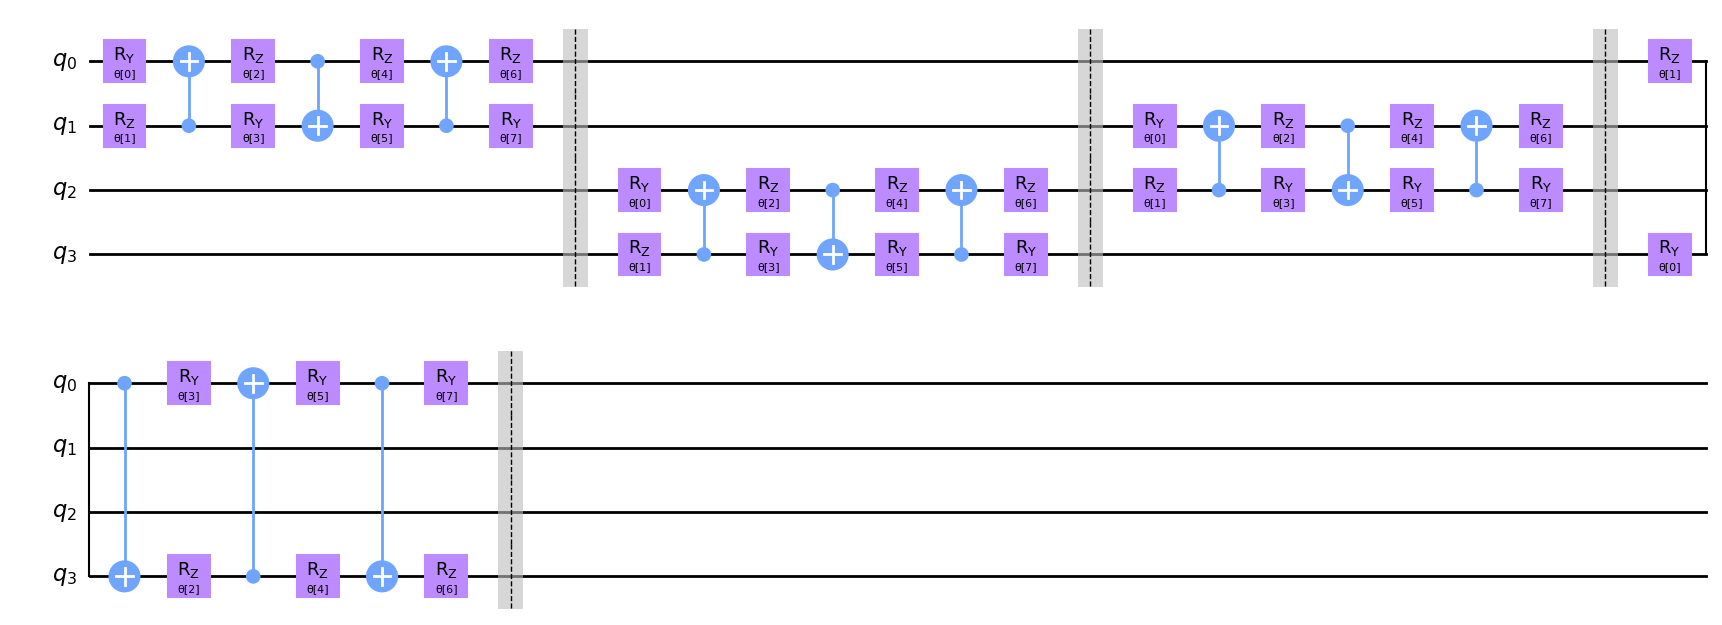

In [176]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=8) #was 3
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        # param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 8)]), [q1, q2]) #was 3
        qc.barrier()
        # param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

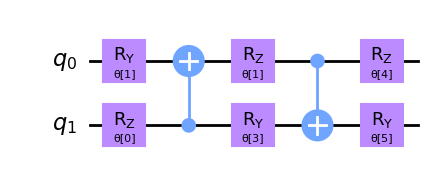

In [177]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(params[0], 1) #was -np.pi / 2
    target.ry(params[1], 0) #new circuit
    target.cx(1, 0)
    target.rz(params[1], 0) #was 0
    target.ry(params[3], 1) #was 1
    target.cx(0, 1)
    target.rz(params[4], 0) #new circuit
    target.ry(params[5], 1) #was 2

    return target


params = ParameterVector("θ", length=6) #was 3
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

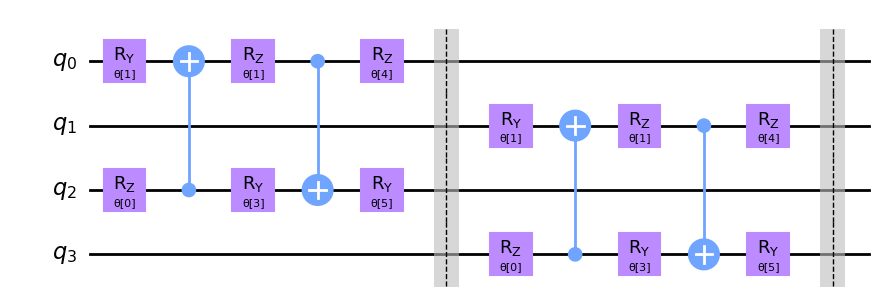

In [178]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=6) #was 3
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 6)]), [source, sink]) #was 3
        qc.barrier()
        # param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

## REAL DATA LOADING STARTS HERE

In [179]:
import pandas as pd

In [180]:
def complex_str_to_float(complex_str):
    complex_num = complex(complex_str)
    return complex_num.real

In [119]:
SIZE = 5

In [124]:
df = pd.read_csv('train_test_df.csv')

sampled_df = df.groupby('phase').apply(lambda x: x.sample(SIZE)).reset_index(drop=True)


X_df = sampled_df.iloc[:, 10:-1]
X_df = X_df.map(complex_str_to_float)

y_df = sampled_df.iloc[:,-1]



X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)
# X_train = 

C:\Users\vokuc\AppData\Local\Temp\ipykernel_42624\54049263.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('phase').apply(lambda x: x.sample(SIZE)).reset_index(drop=True)


make sure that value counts for each phase is equal

In [126]:
y_train.value_counts()

phase
2    4
1    4
3    4
4    4
Name: count, dtype: int64

In [120]:
X_train_list = [x for x in X_train.values]
y_train_list = y_train.values
X_test_list = [x for x in X_test.values]
y_test_list = y_test.values

In [72]:
X_train_list[1].shape

(256,)

In [181]:
# from qiskit.aqua.components.feature_maps import RawFeatureVector

from qiskit_machine_learning.circuit.library.raw_feature_vector import RawFeatureVector
feature_map = RawFeatureVector(256) # ZFeatureMap(8)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

# we decompose the circuit for the QNN to avoid additional data copying
qnn = SamplerQNN(
    circuit=circuit,#.decompose(),
    interpret=lambda measured_int: measured_int >> 6,
    output_shape=4,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [74]:
qnn.output_shape

(4,)

In [183]:
qnn.forward([X_train_list[0]], weights=np.random.rand(26)) #without pooling was 22 #was 12

array([[0.22760965, 0.25102566, 0.2629873 , 0.25837738]])

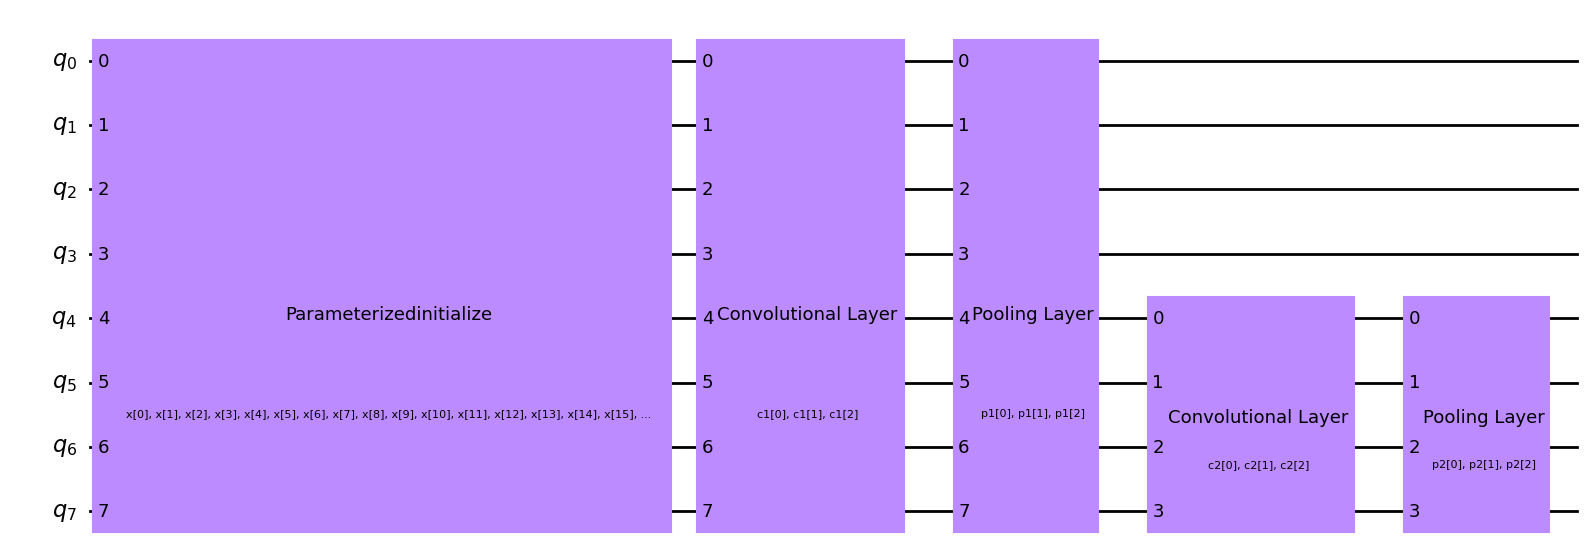

In [76]:
circuit.draw("mpl", style="clifford")

In [184]:
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

In [185]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=1000),  # Set max iterations here
    callback=callback_graph,
    loss='cross_entropy',
    one_hot=True
)

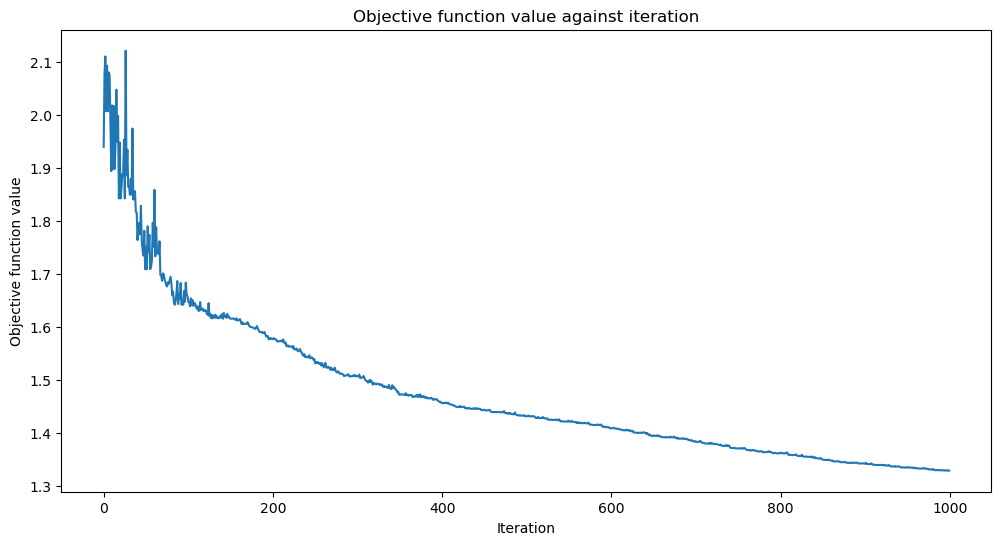

In [186]:
x = np.asarray(X_train_list)
y = np.asarray(y_train_list)

objective_func_vals = []
classifier.fit(x, y)

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

### Testing on small test set

In [187]:
y_test

9     2
3     1
19    4
12    3
Name: phase, dtype: int64

In [188]:
classifier.predict(X_test)

array([2, 1, 4, 3], dtype=int64)

### Testing on a newly sampled test set of size n=50

In [189]:
LOAD_SAMPLE = False
if LOAD_SAMPLE:
    df_sample_big = pd.read_pickle("df_sample_big.pkl")
else:
    df_sample_big = df.groupby('phase').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)
X_test_big = df_sample_big.iloc[:, 10:-1].map(complex_str_to_float)
y_test_big = df_sample_big.iloc[:,-1]
info_test_big = df_sample_big[["J2", "J2", "mag_x", "mesh_y", "mesh_z", "gap", "entropy", "cv", "chi"]]
X_test_big = [x for x in X_test_big.values]
y_test_big = y_test_big.values

C:\Users\vokuc\AppData\Local\Temp\ipykernel_42624\496837897.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample_big = df.groupby('phase').apply(lambda x: x.sample(n=50, random_state=42)).reset_index(drop=True)


In [190]:
print(f"Accuracy: {np.mean(classifier.predict(X_test_big) == y_test_big)}")

Accuracy: 0.93


### Save the sample df

In [171]:
SAVE_SAMPLE = False
if SAVE_SAMPLE:
    df_sample_big.to_pickle("df_sample_big.pkl")

### Save the model and results

In [172]:
import pickle as pkl
SAVE_MODEL = False
SAVE_RESULTS = False

if SAVE_MODEL:
    classifier.save("classifier.obj")
if SAVE_RESULTS:
    with open("results.pkl", 'wb') as f:
        pkl.dump(objective_func_vals, f)

In [103]:
# to load model object, set LOAD_MODEL to True
LOAD_MODEL = True
if LOAD_MODEL:
    loaded_classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=COBYLA(maxiter=1000),  # Set max iterations here
        callback=callback_graph,
    )
    loaded_classifier.load("classifier.obj")

In [106]:
# to load result object, set LOAD_RESULTS to True
LOAD_RESULTS = True
if LOAD_RESULTS:
    with open("results.pkl", 'rb') as f:

        obj_func_vals = pkl.load(f)

## THIS IS THE END OF THE NOTEBOOK

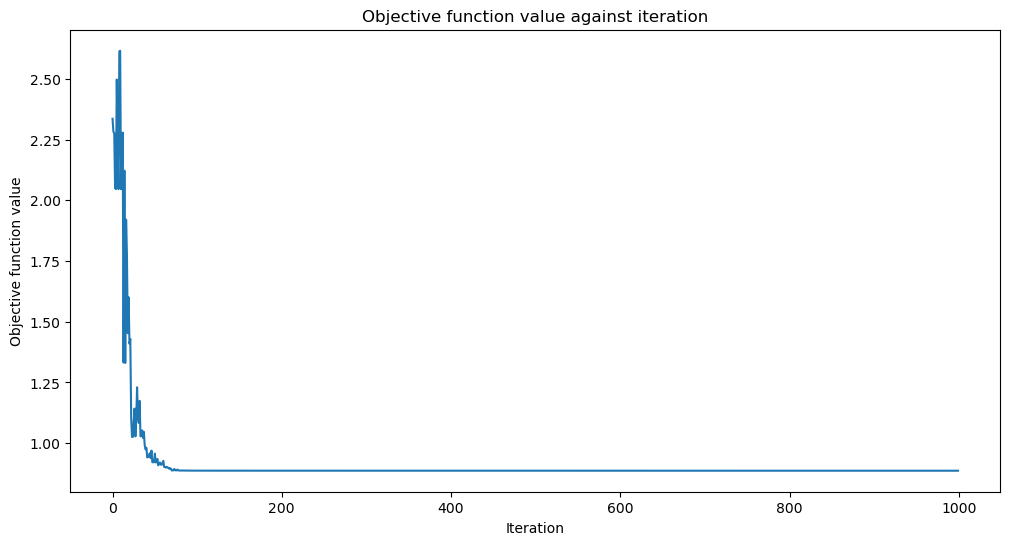

In [23]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
classifier.fit(x, y)

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

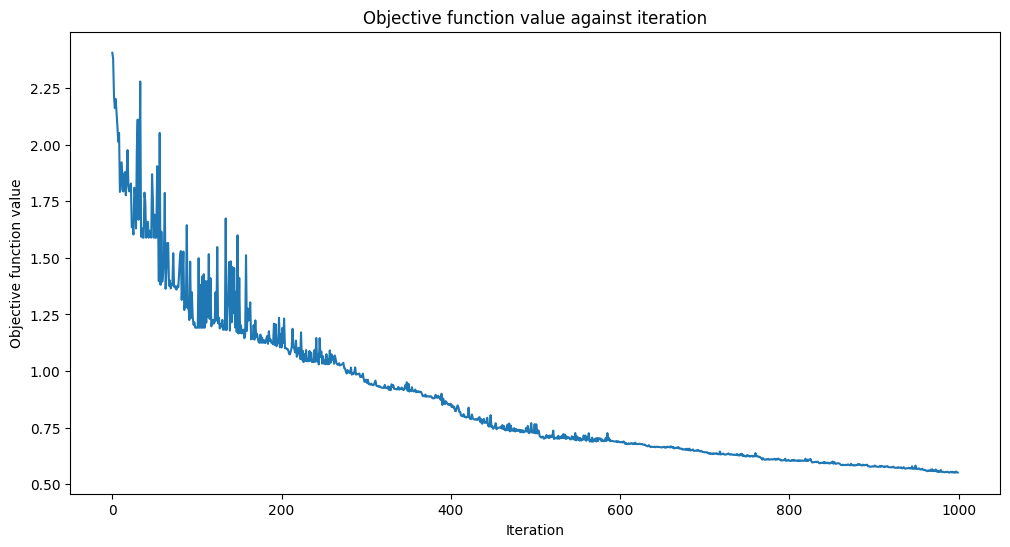

In [55]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
classifier.fit(x, y)

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(objective_func_vals)), objective_func_vals)
plt.show()

In [56]:
# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

Accuracy from the train data : 80.0%


In [57]:
y

array([1, 2, 1, 0, 2, 3, 2, 0, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 3, 0, 2, 2,
       0, 0, 0, 3, 3, 3, 2, 2, 1, 2, 1, 0, 1])

Accuracy from the test data : 86.67%
[0 3 0 0 0 3 2 3 2 2 2 0 2 3 2]


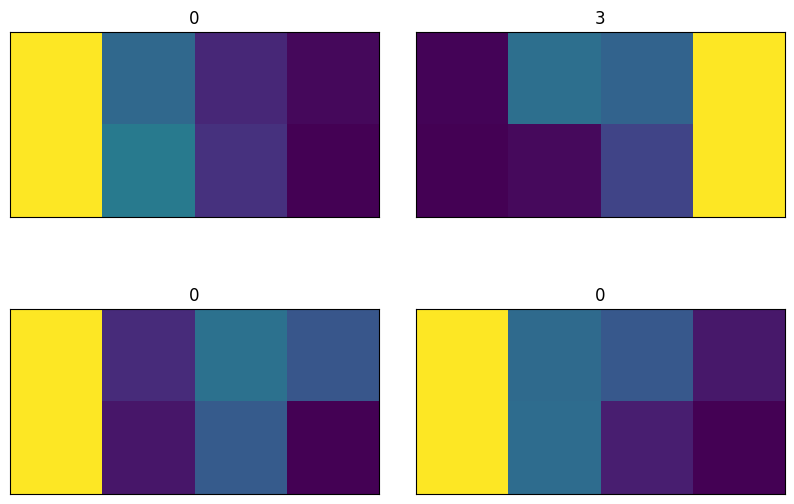

In [58]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
    ax[i // 2, i % 2].set_title(y_predict[i])
plt.subplots_adjust(wspace=0.1, hspace=0.5)
print(y_predict)